# Topological Analysis of Attention Maps in Transformer type models

## Imports

In [2]:
import bertviz
import torch
import numpy as np

from transformers import BertTokenizer, BertModel
from pprint import pprint
from bertviz import head_view, model_view
from typing import Tuple
from typing import List, Optional
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go


from scipy.sparse import csgraph
from scipy.sparse import csr_matrix

## Utility functions

In [3]:
# attention -> tuple len of num layers of (batch_size, num_heads, seq_len, seq_len)

def get_num_layers(attention):
    return len(attention)

def get_num_heads(attention):
    # first layer, first batch element
    return attention[0][0].size(0)

def format_attention(attention, layers=None, heads=None):
    if layers:
        attention = [attention[layer_index] for layer_index in layers]
    squeezed = []
    for layer_attention in attention:
        # print(layer_attention.shape)
        # 1 x num_heads x seq_len x seq_len
        if len(layer_attention.shape) != 4:
            raise ValueError("The attention tensor does not have the correct number of dimensions. Make sure you set "
                             "output_attentions=True when initializing your model.")
        layer_attention = layer_attention.squeeze(0)
        if heads:
            layer_attention = layer_attention[heads]
        squeezed.append(layer_attention)
    # num_layers x num_heads x seq_len x seq_len
    return torch.stack(squeezed)

In [9]:
from typing import Union, Tuple


def plot_barcodes(attention: Tuple,
                  layers: Union[int, List[int], None] = None,
                  heads: Union[int, List[int], None] = None,
                  plot_heatmap: bool = True,
                  plot_barcodes: bool = True,
                  tokens: Optional[List] = None
                  ) -> None:
    f_attention = format_attention(attention)
    f_attention = f_attention.detach().numpy()
    n_tokens = f_attention.shape[-1]

    if heads is None:
        heads = range(get_num_heads(attention))
    elif isinstance(heads, int):
        heads = [heads]
    elif not isinstance(heads, list):
        raise TypeError("Heads must be one of int, List[int], None, got type %s" % type(heads))
        
    if layers is None:
        layers = range(get_num_layers(attention))
    elif isinstance(layers, int):
        layers = [layers]
    elif not isinstance(layers, list):
        raise TypeError("Layers must be one of int, List[int], None, got type %s" % type(layers))

    if plot_barcodes:
        fig, ax =  plt.subplots(len(layers), len(heads), figsize=(len(heads) * 4, len(layers) * 4))
        fig.tight_layout(pad=5.0)

    data = []
    
    for layer in layers:
        data.append([])
        for head in heads:
            graph = f_attention[layer, head]
            graph = 1 - np.where(graph > graph.T, graph, graph.T)
            # flatten graph and sort
            thresholds = sorted(graph.reshape(-1).tolist())
            # print(thresholds)

            used_thresholds = []
            n_connected_components = []
            
            i = n_tokens
            for threshold in thresholds:
                adjacency_matrix = graph <= threshold
                sparse_matrix = csr_matrix(adjacency_matrix)
                n_components, labels = csgraph.connected_components(sparse_matrix)

                if n_components < i:
                    for j in range(i - 1, n_components - 1, -1):
                        used_thresholds.append(threshold)
                        n_connected_components.append(j)
                    i = n_components

                if n_components == 1:
                    break
            data[-1].append([(thresh, ncc) for thresh, ncc in zip(used_thresholds, n_connected_components)])

            if plot_barcodes:
                if len(layers) == 1 and len(heads) == 1: 
                    ax.barh(n_connected_components, used_thresholds) #, align='center')
                    ax.set_xlabel('Thresholds')
                    ax.set_ylabel('Connect. comp.')
                    ax.set_title(f'Head={head}, layer={layer}')
                elif len(layers) == 1 or len(heads) == 1:
                    ax[layer| head].barh(n_connected_components, used_thresholds) #, align='center')
                    ax[layer| head].set_xlabel('Thresholds')
                    ax[layer| head].set_ylabel('Connect. comp.')
                    ax[layer| head].set_title(f'Head={head}, layer={layer}')
                else:
                    ax[layer, head].barh(n_connected_components, used_thresholds) #, align='center')
                    ax[layer, head].set_xlabel('Thresholds')
                    ax[layer, head].set_ylabel('Connect. comp.')
                    ax[layer, head].set_title(f'Head={head}, layer={layer}')

    if plot_barcodes:
        fig.show()

    # if plot_heatmap:
    #     if tokens is None:
    #         tokens = 'auto'
    #     sns.heatmap(graph, annot=True, cmap='viridis', fmt=".2f", xticklabels=tokens, yticklabels=tokens)
    #     plt.title('Attention Matrix')
    #     plt.show()
    
    # if plot_heatmap:
    #     if tokens is None:
    #         tokens = 'auto'
    #     sns.heatmap(graph, annot=True, cmap='viridis', fmt=".2f", xticklabels=tokens, yticklabels=tokens)
    #     plt.title('Attention Matrix')
    #     plt.show()
    return data

In [5]:
def get_attentions(model, tokenizer, text, debug: bool = True, return_tokens: bool = False):
    # token_type_ids
    encoded_input = tokenizer(text, return_tensors='pt')

    debug and print(encoded_input.keys())
    debug and pprint(encoded_input)

    input_ids = encoded_input['input_ids']

    debug and print(input_ids.shape)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0]) 

    debug and print(tokens)

    with torch.no_grad():
        output = model(**encoded_input)
        attention = output['attentions']
        debug and print(attention)
    
    if return_tokens:
        return attention, tokens
    else:
        return attention

## Bert

In [6]:
# Output attentions = TRUE
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text = "I love you"
# text = "A set of words that is complete in itself, typically containing a subject and predicate, conveying a statement, question, exclamation, or command, and consisting of a main clause and sometimes one or more subordinate clause."

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ef2c3543-2a4d-4725-a43b-f5c6b966dca2)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

In [7]:
attention, tokens = get_attentions(model, tokenizer, text, debug=False, return_tokens=True)
# print(attention)
# print(tokens)
# print(len(tokens))

/home/yessense/miniconda/envs/nlp_spring/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


[[[(0.39605867862701416, 4),
   (0.6536305546760559, 3),
   (0.7056947946548462, 2),
   (0.7138828039169312, 1)],
  [(0.14573538303375244, 4),
   (0.2852768898010254, 3),
   (0.5362280607223511, 2),
   (0.9026656746864319, 1)],
  [(0.1305750012397766, 4),
   (0.19694286584854126, 3),
   (0.45422816276550293, 2),
   (0.5151335000991821, 1)],
  [(0.10207521915435791, 4),
   (0.4759732484817505, 3),
   (0.4831181764602661, 2),
   (0.5671592950820923, 1)],
  [(0.679722011089325, 4),
   (0.6806857585906982, 3),
   (0.7073765993118286, 2),
   (0.7136872410774231, 1)],
  [(0.4294542670249939, 4),
   (0.5737418532371521, 3),
   (0.6630256175994873, 2),
   (0.6731820702552795, 1)],
  [(0.4800645709037781, 4),
   (0.662124514579773, 3),
   (0.6943047046661377, 2),
   (0.8839594125747681, 1)],
  [(0.4528820514678955, 4),
   (0.540717363357544, 3),
   (0.6317264437675476, 2),
   (0.7053560018539429, 1)],
  [(0.4758586883544922, 4),
   (0.4810749292373657, 3),
   (0.49889683723449707, 2),
   (0.793

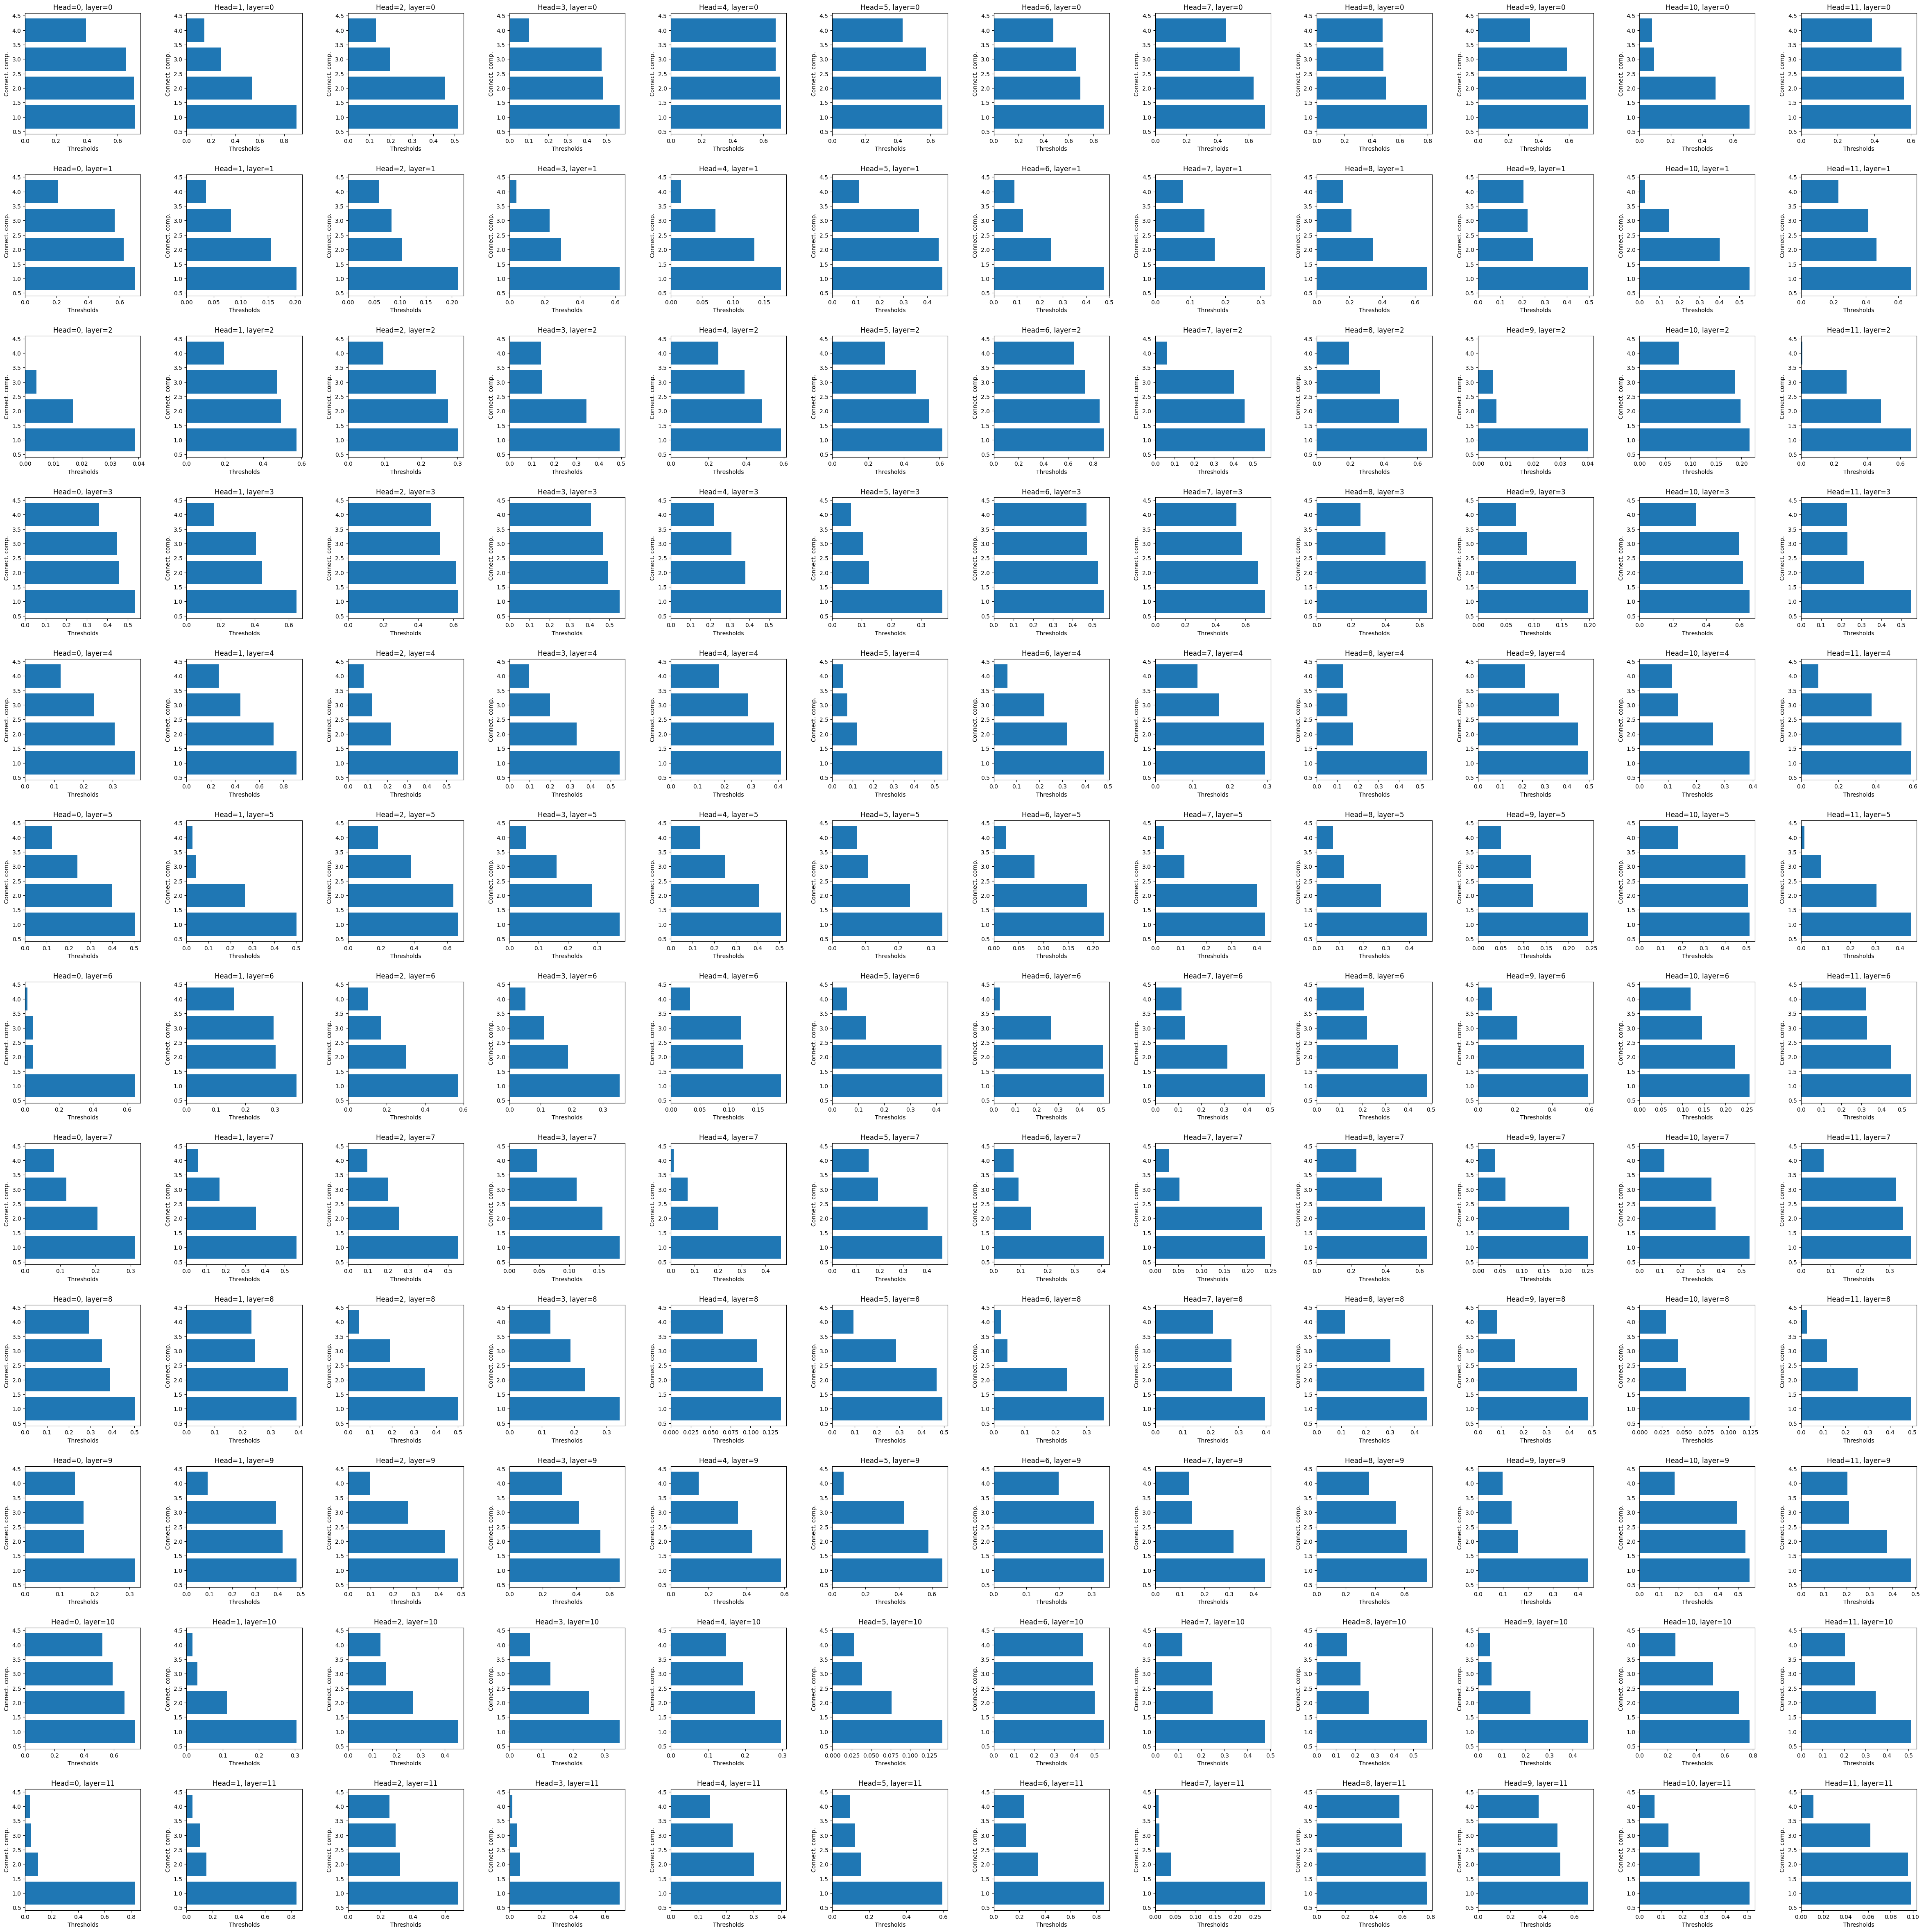

In [10]:
plot_barcodes(attention,
              layers=None, 
              heads=None,
              tokens=tokens)

In [11]:
model_view(attention, tokens)
# head_view(attention, tokens, heads=[6])

<IPython.core.display.Javascript object>

1. Веса внимания (1-вес)
2. Упорядочиваем получившиеся веса по возрастанию
3. Начинаем по одному добавлять, начиная с самого маленького

## Distil Bert

In [12]:
from transformers import AutoTokenizer, DistilBertModel
import torch

model_name = "distilbert-base-uncased"
tokenizer_distil = AutoTokenizer.from_pretrained(model_name)
model_distil = DistilBertModel.from_pretrained(model_name, output_attentions=True)



'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ddb181e3-f6fa-44f4-9ff6-92cfaa5a58ad)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-uncased/resolve/main/config.json
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
attention_distil, tokens_distil = get_attentions(model_distil, tokenizer_distil, text, debug=False, return_tokens=True)
attention_distil

(tensor([[[[1.1143e-01, 1.2307e-01, 1.1304e-01, 2.1529e-01, 4.3717e-01],
           [2.7174e-01, 1.1770e-01, 2.2528e-01, 3.2897e-01, 5.6300e-02],
           [4.1608e-01, 9.4709e-02, 8.9809e-02, 1.4638e-01, 2.5303e-01],
           [3.5951e-01, 2.9282e-01, 1.2104e-01, 1.3204e-01, 9.4602e-02],
           [2.7109e-01, 1.0371e-01, 1.0874e-01, 1.4199e-01, 3.7447e-01]],
 
          [[9.8309e-01, 4.7617e-03, 3.0960e-03, 3.2509e-03, 5.8054e-03],
           [6.9233e-03, 9.3572e-02, 6.3704e-01, 8.9247e-02, 1.7322e-01],
           [1.2279e-02, 3.5424e-02, 4.5873e-01, 9.0971e-02, 4.0260e-01],
           [9.0399e-03, 2.1895e-02, 8.3145e-01, 2.4294e-02, 1.1332e-01],
           [1.9382e-02, 4.4943e-01, 1.0406e-01, 2.2377e-01, 2.0337e-01]],
 
          [[9.0861e-01, 6.6271e-03, 4.9213e-03, 5.0681e-03, 7.4774e-02],
           [9.6325e-01, 6.7396e-03, 6.0008e-04, 1.9585e-03, 2.7457e-02],
           [2.7795e-02, 9.6810e-01, 3.6452e-04, 1.8673e-04, 3.5572e-03],
           [8.7542e-02, 7.6619e-04, 9.0594e-0

/home/yessense/miniconda/envs/nlp_spring/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


[[[(0.5628284215927124, 4),
   (0.5839204788208008, 3),
   (0.6404949426651001, 2),
   (0.6710302829742432, 1)],
  [(0.16855329275131226, 4),
   (0.36296015977859497, 3),
   (0.5505737662315369, 2),
   (0.9806182384490967, 1)],
  [(0.031903088092803955, 4),
   (0.0367547869682312, 3),
   (0.09405553340911865, 2),
   (0.4971967339515686, 1)],
  [(0.20552140474319458, 4),
   (0.321696400642395, 3),
   (0.48537302017211914, 2),
   (0.5613254904747009, 1)],
  [(0.1827523112297058, 4),
   (0.43546152114868164, 3),
   (0.49631690979003906, 2),
   (0.7341964244842529, 1)],
  [(0.38519299030303955, 4),
   (0.4833926558494568, 3),
   (0.5402427911758423, 2),
   (0.6017292737960815, 1)],
  [(0.11571180820465088, 4),
   (0.6812861561775208, 3),
   (0.7048717141151428, 2),
   (0.8019464612007141, 1)],
  [(0.437211275100708, 4),
   (0.4719148278236389, 3),
   (0.5487598180770874, 2),
   (0.5708892345428467, 1)],
  [(0.24344223737716675, 4),
   (0.24719488620758057, 3),
   (0.4852219223976135, 2),
 

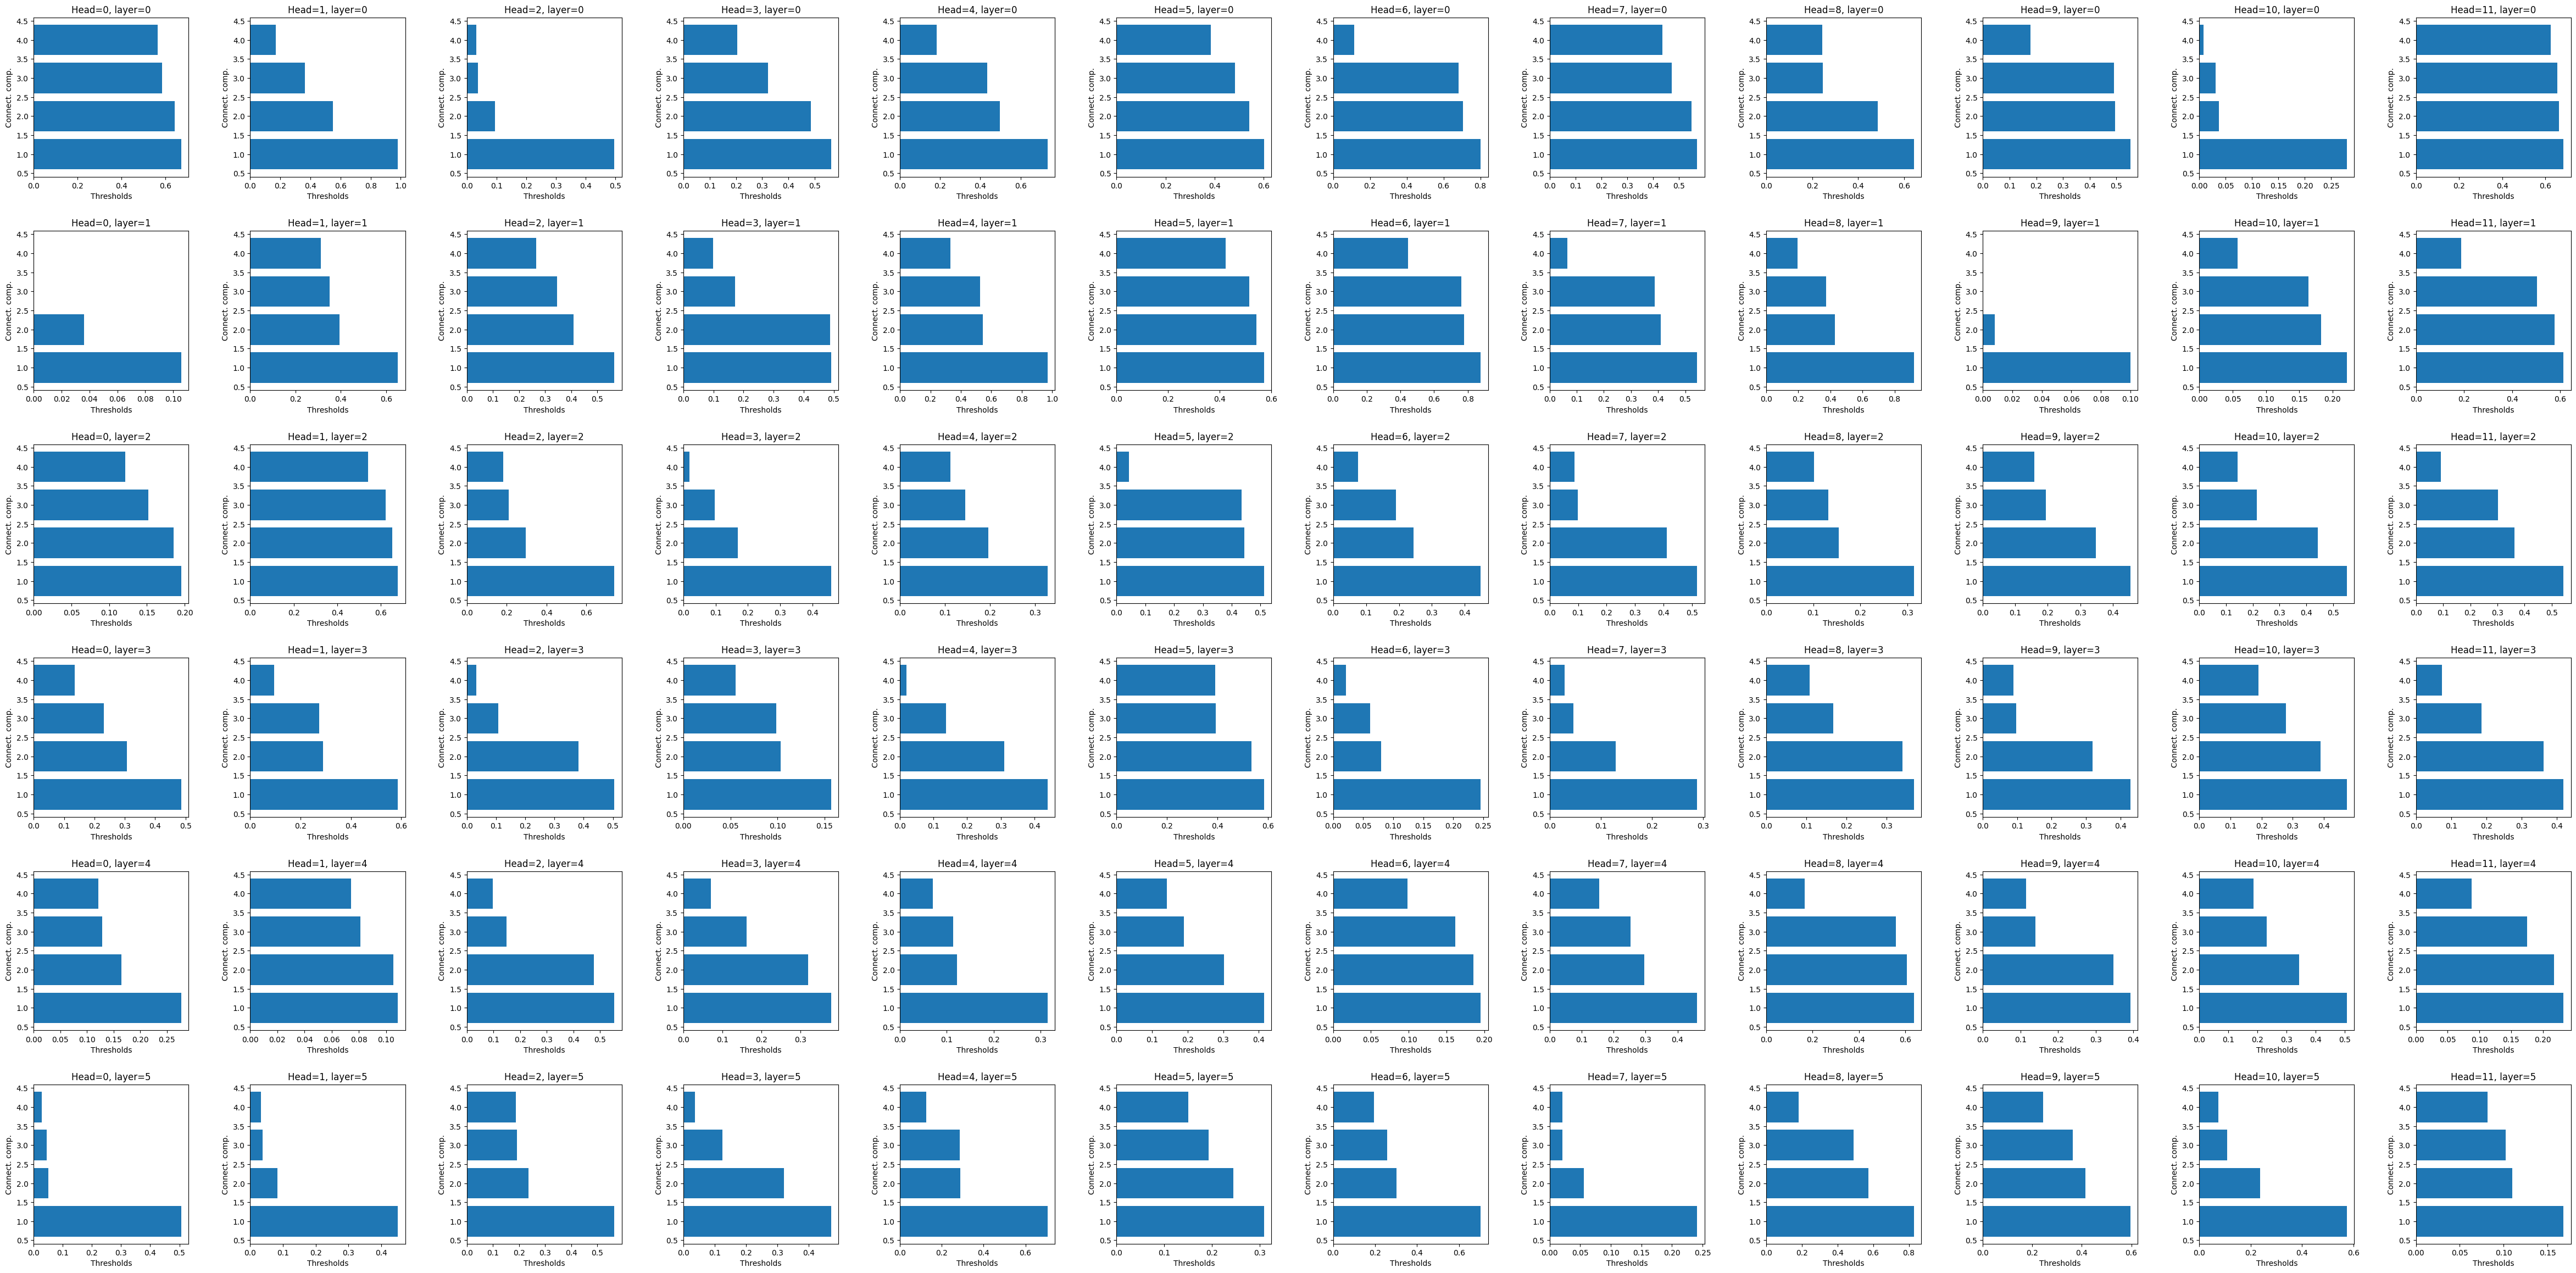

In [14]:
plot_barcodes(attention_distil, None, None, tokens=tokens)

In [15]:
model_view(attention_distil, tokens_distil)

<IPython.core.display.Javascript object>

In [16]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [17]:
#  !pip install git+https://github.com/ArGintum/RipserZeros.git

def rtd(a, b, dim=1, mode='max'):
  # Parameters:
  #           a    - adjacency matrix (symmetric) of the first graph
  #           b    - adjacency matrix (symmetric) of the first graph
  #           dim  - dimension of RTD. Default: 1 (in all our experiments we used this value only)
  #           mode - variant of RTD to use. Default: 'max' (in all our experiments we used this value only)

  # Returns: list of bars of RTD(, ) in dimension 

  if mode != 'max' and mode != 'min':
     raise ValueError("Wrong Value for 'mode' parameter. RTD mode can be either 'min' or 'max' ")

  n = a.shape[0]
  d = np.zeros((2 * n, 2 * n))
  
  if mode == 'max':
    d[n:, :n] = torch.maximum(a.cpu(), b.cpu()).detach().numpy()  
    d[:n, n:] = torch.maximum(a.cpu(), b.cpu()).detach().numpy()  
    d[n:, n:] = b.cpu().detach().numpy()
  else:
    d[n:, :n] = a.cpu().detach().numpy()
    d[:n, n:] = a.cpu().detach().numpy()
    d[n:, n:] = torch.minimum(a.cpu(), b.cpu()).detach().numpy() 

  m = d[n:, :n].mean()
  d[d < m*(1e-6)] = 0
  results = rpp_py.run("--format distance --mode rtd --dim " + str(dim), d)['dgms'][dim]
  return results
